## Vanilla 2 Layer MLP using CIFAR-10 as dataset

In [27]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Preprocess (전처리)

In [29]:
# Simple transformation
transform = transforms.Compose([
    # Convert PIL Image to tensor
    transforms.ToTensor(),
    # Normalize the tensor to have mean 0.5 and std 0.5 for each channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Flatten the 3D tensor (C, H, W) to 1D tensor (C*H*W) for MLP input
    transforms.Lambda(lambda x: x.view(-1)),
])

# Load CIFAR-10 train/test dataset and transform it
train_set = datasets.CIFAR10(
    root="../data",
    train=True,
    download=True,
    transform=transform)

test_set = datasets.CIFAR10(
    root="../data",
    train=False,
    download=True,
    transform=transform)

In [30]:
# Data loaders for batch learning

BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

## Define Neural Network

In [31]:
n_input = 32 * 32 * 3
n_hidden = 256
n_output = test_set.classes.__len__() # 10 classes
print(f" n_input: {n_input},\n n_hidden: {n_hidden},\n n_output: {n_output}")

 n_input: 3072,
 n_hidden: 256,
 n_output: 10


In [32]:
class MLP(nn.Module):
    # define each layers
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    # define the forward pass
    # x is input tensor
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [33]:
net = MLP(n_input, n_hidden, n_output).to(device)
print(net)

MLP(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [34]:
for parameter in net.named_parameters():
    print(parameter)

('fc1.weight', Parameter containing:
tensor([[ 0.0031,  0.0068,  0.0025,  ...,  0.0086, -0.0158, -0.0025],
        [ 0.0171,  0.0099, -0.0173,  ...,  0.0106,  0.0013,  0.0028],
        [-0.0174, -0.0122, -0.0165,  ...,  0.0052,  0.0111, -0.0138],
        ...,
        [-0.0169,  0.0121,  0.0001,  ...,  0.0094,  0.0155, -0.0036],
        [-0.0117,  0.0064, -0.0048,  ..., -0.0144,  0.0096,  0.0147],
        [ 0.0101, -0.0067,  0.0116,  ..., -0.0033,  0.0015, -0.0133]],
       device='cuda:0', requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 4.6962e-03, -8.8282e-03, -6.2503e-04, -9.7158e-03,  1.3028e-02,
        -2.3707e-03,  1.0464e-02,  5.5914e-04,  8.6069e-03, -7.9907e-03,
         3.0410e-03, -1.4071e-02, -4.2286e-03, -1.6780e-02, -1.1409e-02,
        -6.9428e-03, -8.3330e-03,  7.1488e-04,  1.0912e-02,  1.6824e-02,
         3.3637e-03,  6.4993e-05,  5.5351e-03,  1.3842e-02,  9.9244e-03,
        -6.5741e-03,  1.3434e-02, -4.6620e-03, -1.0820e-02,  1.5454e-02,
        -1.

## Define Loss Function and Optimizer

In [35]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

In [36]:
# Training loop
EPOCHS = 30
history = np.zeros((0,5))

## Train and Test the Model

In [37]:
from tqdm.notebook import tqdm
for epoch in range(EPOCHS):
    train_correct, train_loss = 0, 0
    val_correct, val_loss = 0, 0
    n_train, n_test = 0, 0

    net.train()
    for inputs, labels in tqdm(train_loader):
        # recap: train loader yields batches (each size of 64) of (inputs, labels)
        # len(labels) = train_dataset / batch_size = 50000 / 64 = 781.25 -> 782 batches
        n_train += len(labels)

        # sends variables to device(gpu)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # output(result of net) is already a tensor thus no need to move to device
        outputs = net(inputs) # (64, 10)
        loss = criterion(outputs, labels)
        # backprop
        loss.backward()
        # update parameters
        optimizer.step()

        # torch .argmax returns the indices of the maximum 
        # value of all elements in the input tensor
        # dim=1 indicates that the max is computed along each row
        predicted = torch.argmax(outputs, dim=1)
        # use .item() to get a python number from a tensor type
        # this collects the total loss in a batch(size of 64) and accumulated 782 times(total batches)
        # IMPORTANT: loss.item() gives the average loss per sample in the batch so we need to multiply by batch size to get total loss
        train_loss += loss.item() * BATCH_SIZE
        # collects the number of correct predictions in a batch(size of 64)
        train_correct += (predicted == labels).sum().item()
    
    net.eval()
    with torch.no_grad():
        for inputs_test, labels_test in test_loader:
            # len(labels_test) = test_dataset / batch_size = 10000 / 64 = 156.25 -> 157 batches
            n_test += len(labels_test)
            inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
            outputs_test = net(inputs_test)
            loss_test = criterion(outputs_test, labels_test)

            predicted_test = torch.argmax(outputs_test, dim=1)
            val_loss += loss_test.item() * BATCH_SIZE
            val_correct += (predicted_test == labels_test).sum().item()
        
    train_loss = train_loss / n_train
    val_loss = val_loss / n_test
    train_acc = train_correct / n_train
    val_acc = val_correct / n_test

    print(f"Epoch {epoch+1}/{EPOCHS}, \
        train loss: {train_loss:.4f}, \
        train acc: {train_acc:.4f}, \
        val loss: {val_loss:.4f}, \
        val acc: {val_acc:.4f}")

    history = np.vstack((
    history,
    np.array([epoch+1, train_loss, train_acc, val_loss, val_acc])
    ))


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/30,         train loss: 1.8819,         train acc: 0.3443,         val loss: 1.7263,         val acc: 0.4020


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/30,         train loss: 1.6626,         train acc: 0.4213,         val loss: 1.6283,         val acc: 0.4345


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/30,         train loss: 1.5800,         train acc: 0.4503,         val loss: 1.5647,         val acc: 0.4572


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/30,         train loss: 1.5258,         train acc: 0.4694,         val loss: 1.5270,         val acc: 0.4691


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/30,         train loss: 1.4834,         train acc: 0.4859,         val loss: 1.5010,         val acc: 0.4828


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/30,         train loss: 1.4458,         train acc: 0.4992,         val loss: 1.4736,         val acc: 0.4858


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/30,         train loss: 1.4119,         train acc: 0.5120,         val loss: 1.4506,         val acc: 0.4952


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/30,         train loss: 1.3816,         train acc: 0.5239,         val loss: 1.4311,         val acc: 0.5027


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/30,         train loss: 1.3515,         train acc: 0.5340,         val loss: 1.4203,         val acc: 0.5026


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/30,         train loss: 1.3254,         train acc: 0.5455,         val loss: 1.4100,         val acc: 0.5044


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11/30,         train loss: 1.2996,         train acc: 0.5559,         val loss: 1.4041,         val acc: 0.5092


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12/30,         train loss: 1.2772,         train acc: 0.5633,         val loss: 1.3836,         val acc: 0.5152


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13/30,         train loss: 1.2535,         train acc: 0.5714,         val loss: 1.3731,         val acc: 0.5195


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14/30,         train loss: 1.2305,         train acc: 0.5788,         val loss: 1.3768,         val acc: 0.5170


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15/30,         train loss: 1.2101,         train acc: 0.5871,         val loss: 1.3651,         val acc: 0.5205


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16/30,         train loss: 1.1896,         train acc: 0.5948,         val loss: 1.3644,         val acc: 0.5212


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17/30,         train loss: 1.1717,         train acc: 0.6011,         val loss: 1.3685,         val acc: 0.5213


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18/30,         train loss: 1.1512,         train acc: 0.6089,         val loss: 1.3542,         val acc: 0.5230


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19/30,         train loss: 1.1326,         train acc: 0.6133,         val loss: 1.3507,         val acc: 0.5286


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20/30,         train loss: 1.1137,         train acc: 0.6229,         val loss: 1.3509,         val acc: 0.5261


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 21/30,         train loss: 1.0960,         train acc: 0.6291,         val loss: 1.3509,         val acc: 0.5284


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 22/30,         train loss: 1.0783,         train acc: 0.6349,         val loss: 1.3356,         val acc: 0.5318


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 23/30,         train loss: 1.0615,         train acc: 0.6401,         val loss: 1.3508,         val acc: 0.5272


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 24/30,         train loss: 1.0439,         train acc: 0.6482,         val loss: 1.3541,         val acc: 0.5285


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 25/30,         train loss: 1.0272,         train acc: 0.6536,         val loss: 1.3388,         val acc: 0.5376


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 26/30,         train loss: 1.0113,         train acc: 0.6615,         val loss: 1.3617,         val acc: 0.5331


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 27/30,         train loss: 0.9952,         train acc: 0.6652,         val loss: 1.3512,         val acc: 0.5339


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 28/30,         train loss: 0.9805,         train acc: 0.6710,         val loss: 1.3515,         val acc: 0.5326


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 29/30,         train loss: 0.9645,         train acc: 0.6753,         val loss: 1.3819,         val acc: 0.5253


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 30/30,         train loss: 0.9490,         train acc: 0.6831,         val loss: 1.3531,         val acc: 0.5363


## Visualize and Assess Result

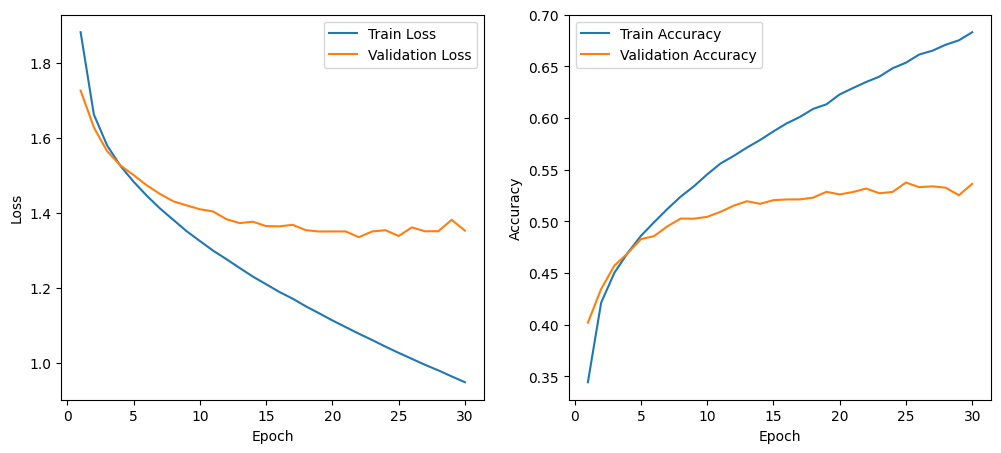

In [38]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0], history[:,1], label='Train Loss')
plt.plot(history[:,0], history[:,3], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history[:,0], history[:,2], label='Train Accuracy')
plt.plot(history[:,0], history[:,4], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Conclusion: vanilla mlp isn't that good.